In [43]:
import numpy as np
from numpy.fft import fft
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
NL = 10
NA = NL+1
D = 1
d = D/NL

In [45]:
atm = ceo.Atmosphere(0.15,25)

In [46]:
ngs = ceo.Source("V",resolution=(NA,NA))

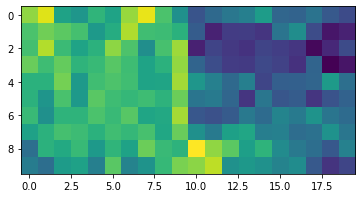

In [47]:
d = D/NL
cog = ceo.Centroiding(NL,N_SOURCE=ngs.size)
atm.get_phase_screen_gradient(cog,NL,d,ngs,0.0)
c = cog.c.host(units='arcsec')

plt.imshow(c.reshape(NL*ngs.size*2,NL).transpose())

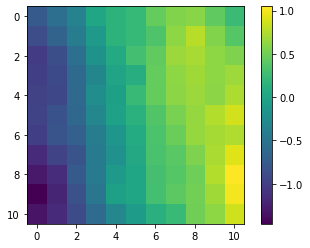

In [48]:
src = ceo.Source("K",resolution=(NA,NA))
atm.get_phase_screen(src,d,NA,d,NA,0)
ps = 1e6*src.phase.host()
ps -= ps.mean()
plt.imshow(ps)
plt.colorbar()

In [49]:
aa = ceo.AaStatsMatrix(NL,atm,d,src)

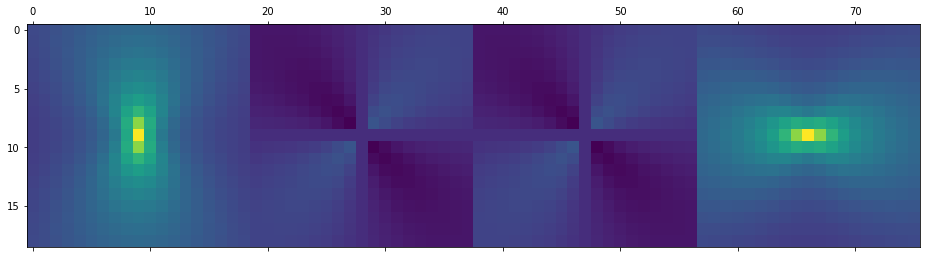

In [50]:
plt.matshow(aa.cov.host().T)

In [51]:
t = ceo.Btbt(2,2,NL,NL,aa.cov)

In [52]:
v = np.zeros(cog.c.size)
x = ceo.cuFloatArray(host_data=v)
x0 = ceo.cuFloatArray(host_data=v)

In [53]:
s = ceo.Minres(cog.c.size)

In [54]:
s.N_ITERATION = 1000
s.RTOL = 1e-9
s.ATOL = 1e-9

In [55]:
s.solve(x,t,cog.c,x0)

In [56]:
s.cvgce_iteration,s.RTOL,s.ATOL

(247, 9.999999717180685e-10, 9.999999717180685e-10)

In [57]:
y = t.MVM(x.host())

In [58]:
pa = ceo.PaStats(NA,NL,1,atm,d,src,ngs)

In [59]:
g = ceo.Gbtbt(1,2,NA,NL,pa.cov)

In [60]:
y = g.MVM(x.host())

In [61]:
pse = y.host().reshape(NA,NA)*1e6
pse -= pse.mean()

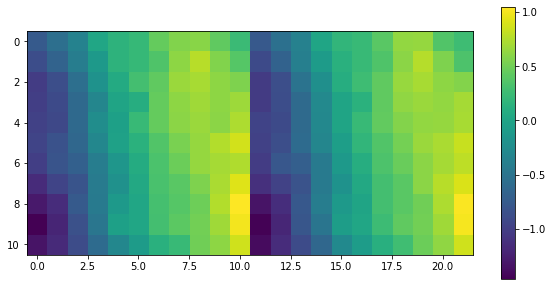

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(np.hstack([ps,pse]))
plt.colorbar()

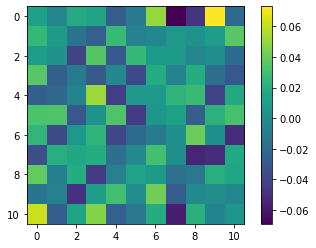

In [63]:
plt.imshow(ps-pse)
plt.colorbar()